# SCADAA Report

In [1]:
import numpy as np
from numpy.linalg import inv
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from exercise2 import DGM_Layer, Net_DGM
from exercise2 import FFN


## Exercise 1.1

In [20]:
class LQR:
    def __init__(self, H, M, sigma, alpha, alpha_s, C, D, R, T) -> None:
        self.H = H 
        self.M = M
        self.sigma = sigma
        self.alpha = alpha 
        self.alpha_s = alpha_s
        self.C = C 
        self.D = D 
        self.R = R
        self.T = T

    
    # def ricatti_ode(self, t, S):
    #     return (-2 * (np.transpose(self.H))@S.reshape(2,2) 
    #             + S.reshape(2,2)@(self.M)@(torch.inverse(self.D))@(self.M)@S.reshape(2,2) 
    #             - self.C).flatten()
    
    def riccati_ode(self, t, S_flat):
        S = torch.tensor(S_flat).reshape((2, 2))  # Convert S_flat to a PyTorch tensor
        dS = (-2 * (self.H.t() @ S) + S @ (self.M) @ (torch.inverse(self.D)) @ (self.M) @ S - self.C)
        return dS.flatten().detach().numpy()
 
    def solve_lqr(self, time_grid):
        """
        Solves the LQR problem by integrating the 
        Riccati equation backwards in time.
        """
        # Time points (reversed for backward integration)
        # t_points = np.linspace(0, self.T, 1000)[::-1]  
        intial_cond = self.R.flatten().detach().numpy()

        sol = solve_ivp(
            self.riccati_ode, [self.T.item(), time_grid[0].item()], 
            intial_cond, t_eval=time_grid.numpy()[::-1], method='RK45'
            )
        
        S = [torch.tensor(sol.y[:, i].reshape((2, 2))) for i in range(len(sol.t))]
    
        return S

    def visualize_results(self, t_points, S):
        """
        Visualizes the solution of the Riccati equation 
        or the state/control trajectories.
        """
        S_00 = [s[0, 0].item() for s in S]
        plt.plot(t_points, S_00)
        plt.xlabel('Time')
        plt.ylabel('S[0,0]')
        plt.title('Solution of Riccati Equation over Time')
        plt.show()
        

    def markov_control(self, time_grid, x):
        S = self.solve_lqr(time_grid)
        a = torch.tensor(len(t), dtype=torch.float32)
        for t in range(len(t)):
            for x in range(x.shape[1]):
                a[t, x] = -inv(self.D) @ np.transpose(self.M) @ S[:, t].reshape(2, 2) * x[t, x]
        return a

    # this function is incomplete!
    # still trying to figure out the sizes of the tensors
    # i'm confused about batch size :(
    def value_function(self, t, x):
        S, t_points = self.solve_lqr()
        v1 = np.transpose(x) @ S[:, t].reshape(2, 2) @ x
        v2 = np.trace(self.sigma @ np.transpose(self.sigma) @ S)
        return v1 + v2


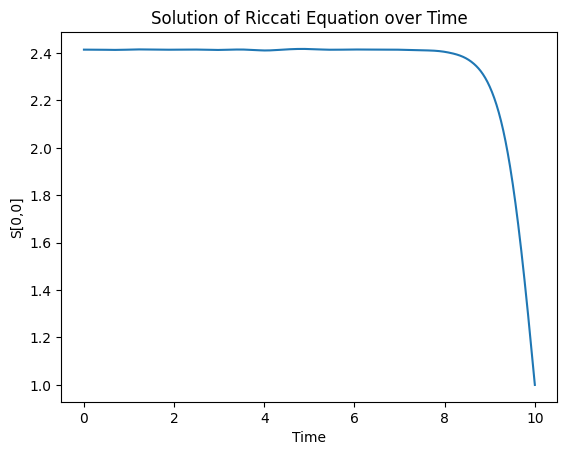

In [22]:
# Example Usage:
# Define problem matrices
H = torch.tensor([[1, 0], [0, 1]], dtype=torch.float64)
M = torch.tensor([[1, 0], [0, 1]], dtype=torch.float64)
D = torch.tensor([[1, 0], [0, 1]], dtype=torch.float64)
C = torch.tensor([[1, 0], [0, 1]], dtype=torch.float64)
R = torch.tensor([[1, 0], [0, 1]], dtype=torch.float64)
T = torch.tensor(10.0, dtype=torch.float64)
sigma = np.array([[0, 0], [0, 0]])
alpha = np.array([[0, 0], [0, 0]])
alpha_s = np.array([[0, 0], [0, 0]])

# Initialize LQRController
# controller = LQRController(H, M, D, C, R, T)

# Define time grid
time_grid = torch.linspace(0, T, 1000)

# Define state values
x_values = torch.tensor([[[0.5, 0.5]], [[1.0, 1.0]]], dtype=torch.float64)  # Example state values

lqr_system = LQR(H, M, sigma, alpha, alpha_s, C, D, R, T)
S_solution = lqr_system.solve_lqr(time_grid)
t_points = np.linspace(0, T, 1000)[::-1]  
lqr_system.visualize_results(t_points, S_solution)


In [ ]:
# Function to generate training data
def generate_training_data(T, num_samples):
    t = np.random.uniform(0, T, num_samples)
    x = np.random.uniform(-3, 3, (num_samples, 2))
    return t, x

# Main training function
def train_value_function(net, T, num_samples, num_epochs, lr):
    optimizer = optim.Adam(net.parameters(), lr=lr)
    criterion = nn.MSELoss()

    losses = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        t, x = generate_training_data(T, num_samples)
        v = compute_value_function(t, x)

        input_data = torch.tensor(x, dtype=torch.float)
        output_data = torch.tensor(v, dtype=torch.float)

        outputs = net(input_data)
        loss = criterion(outputs, output_data)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss Plot')
    plt.show()

# Set parameters
T = 1
num_samples = 1000
num_epochs = 100
lr = 0.001

# Initialize the neural network
net = DGM_Layer()

# Train the value function
train_value_function(net, T, num_samples, num_epochs, lr)

In [3]:

sizes = [input_size, 100, 100, output_size]  # Specify sizes of input, hidden, and output layers
ffn_model = FFN(sizes)